In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import gradio as gr
import json

In [13]:
print("Setting up NLTK...")


nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords')
nltk.download('wordnet')



Setting up NLTK...


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Load the dataset

df = pd.read_excel('ai_dev_assignment_tickets_complex_1000.xls')


print("Initial dataset size:", df.shape)
initial_rows = len(df)
df.dropna(subset=['issue_type', 'urgency_level'], inplace=True)
print(f"Dropped {initial_rows - len(df)} rows with missing labels.")
print("Cleaned dataset size:", df.shape)


print("\nFirst 5 Rows of Cleaned Data:")
display(df.head())
print("\nDataset Info:")
df.info()

Initial dataset size: (1000, 5)
Dropped 124 rows with missing labels.
Cleaned dataset size: (876, 5)

First 5 Rows of Cleaned Data:


,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
5,6,Can you tell me more about the PhotoSnap Cam w...,General Inquiry,Medium,PhotoSnap Cam
6,7,is malfunction. It stopped working after just...,Product Defect,Low,EcoBreeze AC



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticket_id      876 non-null    int64 
 1   ticket_text    826 non-null    object
 2   issue_type     876 non-null    object
 3   urgency_level  876 non-null    object
 4   product        876 non-null    object
dtypes: int64(1), object(4)
memory usage: 41.1+ KB


### Data Exploration and Visualization


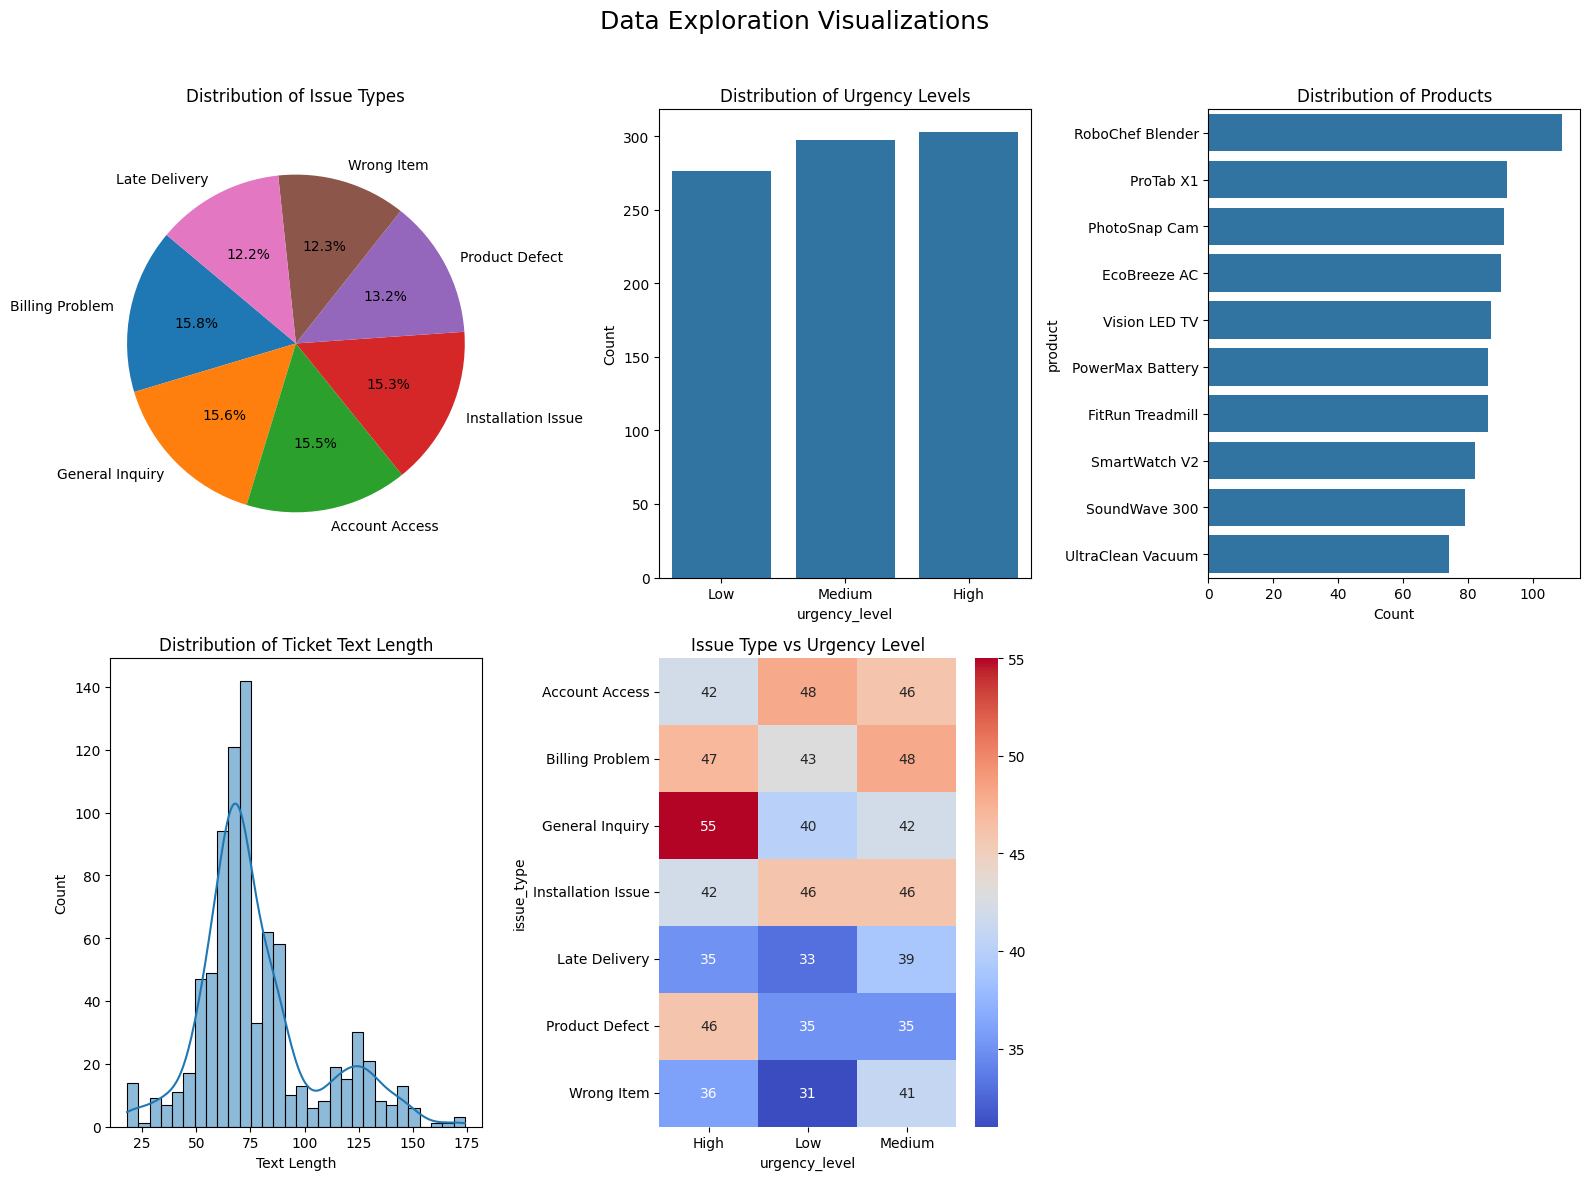

In [15]:
plt.figure(figsize=(16, 12))
plt.suptitle('Data Exploration Visualizations', fontsize=18)

# Issue type distribution
plt.subplot(2, 3, 1)
issue_counts = df['issue_type'].value_counts()
plt.pie(issue_counts.values, labels=issue_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Issue Types')
plt.axis('equal')

# Urgency level distribution
plt.subplot(2, 3, 2)
urgency_counts = df['urgency_level'].value_counts()
sns.barplot(x=urgency_counts.index, y=urgency_counts.values, order=['Low', 'Medium', 'High'])
plt.title('Distribution of Urgency Levels')
plt.ylabel('Count')

# Product distribution
plt.subplot(2, 3, 3)
product_counts = df['product'].value_counts()
sns.barplot(y=product_counts.index, x=product_counts.values, orient='h')
plt.title('Distribution of Products')
plt.xlabel('Count')

# Text length distribution
plt.subplot(2, 3, 4)
df['text_length'] = df['ticket_text'].str.len()
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Ticket Text Length')
plt.xlabel('Text Length')

# Heatmap of issue type vs urgency
plt.subplot(2, 3, 5)
crosstab = pd.crosstab(df['issue_type'], df['urgency_level'])
sns.heatmap(crosstab, annot=True, fmt='d', cmap='coolwarm')
plt.title('Issue Type vs Urgency Level')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Data Preprocessing and Cleaning

In [16]:
class TextPreprocessor:
   
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess_text(self, text):
        """Complete preprocessing pipeline for a single text."""
        if pd.isna(text):
            return ""
        # Lowercase, remove special characters
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())

        # Tokenize and lemmatize
        tokens = word_tokenize(text)
        lemmatized_tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words and len(token) > 2
        ]
        return ' '.join(lemmatized_tokens)

    def extract_sentiment(self, text):
        """Extract sentiment polarity score."""
        if pd.isna(text):
            return 0.0
        return TextBlob(text).sentiment.polarity

# Apply preprocessing
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['ticket_text'].apply(preprocessor.preprocess_text)
df['sentiment_score'] = df['ticket_text'].apply(preprocessor.extract_sentiment)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()) if x else 0)

### Feature Engineering

In [17]:
class FeatureEngineer:

    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2)
        self.is_fitted = False

    def fit_transform_tfidf(self, texts):
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
        self.is_fitted = True
        return tfidf_matrix

    def transform_tfidf(self, texts):
        if not self.is_fitted:
            raise ValueError("TF-IDF vectorizer not fitted yet!")
        return self.tfidf_vectorizer.transform(texts)

    def create_additional_features(self, df):
        features_df = pd.DataFrame()
        features_df['text_length'] = df['text_length']
        features_df['word_count'] = df['word_count']
        features_df['sentiment_score'] = df['sentiment_score']
        features_df['question_marks'] = df['ticket_text'].str.count('\?').fillna(0)
        features_df['exclamation_marks'] = df['ticket_text'].str.count('!').fillna(0)
        features_df['caps_ratio'] = df['ticket_text'].apply(
            lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
        )
        return features_df

feature_engineer = FeatureEngineer()
tfidf_features = feature_engineer.fit_transform_tfidf(df['cleaned_text'].fillna(''))
additional_features = feature_engineer.create_additional_features(df)

### Entity Extraction


In [18]:
class EntityExtractor:
   
    def __init__(self):
        self.products = df['product'].unique().tolist()
        self.complaint_keywords = [
            'broken', 'defective', 'malfunction', 'error', 'bug', 'issue', 'problem', 'late',
            'delayed', 'slow', 'not working', 'failed', 'damaged', 'disappointed', 'frustrated',
            'angry', 'terrible', 'awful', 'bad', 'refund', 'return', 'exchange', 'complaint'
        ]

    def extract_entities(self, text):
        if pd.isna(text): return {}
        text_lower = text.lower()
        
        # Extract products
        found_products = [product for product in self.products if str(product).lower() in text_lower]

        # Extract dates
        date_patterns = r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b|\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},?\s+\d{4}\b'
        found_dates = re.findall(date_patterns, text, re.IGNORECASE)
        
        # Extract keywords
        found_keywords = [kw for kw in self.complaint_keywords if kw in text_lower]

        return {
            'products': list(set(found_products)),
            'dates': list(set(found_dates)),
            'complaint_keywords': list(set(found_keywords))
        }

entity_extractor = EntityExtractor()

### Model Training and Evaluation

In [19]:
class TicketClassifier:
   
    def __init__(self):
        self.issue_classifier = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=15, class_weight='balanced')
        self.urgency_classifier = RandomForestClassifier(n_estimators=150, random_state=42, max_depth=15, class_weight='balanced')
        self.feature_engineer = feature_engineer
        self.entity_extractor = entity_extractor
        self.label_encoders = {}
        self.models_trained = False

    def prepare_data(self, df, tfidf_features, additional_features):
        X = np.hstack([tfidf_features.toarray(), additional_features.values])
        le_issue = LabelEncoder()
        le_urgency = LabelEncoder()
        y_issue = le_issue.fit_transform(df['issue_type'])
        y_urgency = le_urgency.fit_transform(df['urgency_level'])
        self.label_encoders['issue'] = le_issue
        self.label_encoders['urgency'] = le_urgency
        return X, y_issue, y_urgency

    def train(self, X_train, y_issue_train, y_urgency_train):
        self.issue_classifier.fit(X_train, y_issue_train)
        self.urgency_classifier.fit(X_train, y_urgency_train)
        self.models_trained = True

    def predict(self, ticket_text):
        if not self.models_trained:
            raise ValueError("Models not trained yet!")

        cleaned_text = preprocessor.preprocess_text(ticket_text)
        tfidf_single = self.feature_engineer.transform_tfidf([cleaned_text])

        temp_df = pd.DataFrame({'ticket_text': [ticket_text], 'text_length': [len(ticket_text)],
                                'word_count': [len(cleaned_text.split())], 'sentiment_score': [preprocessor.extract_sentiment(ticket_text)]})
        additional_single = self.feature_engineer.create_additional_features(temp_df)

        X_single = np.hstack([tfidf_single.toarray(), additional_single.values])

        issue_pred = self.issue_classifier.predict(X_single)[0]
        urgency_pred = self.urgency_classifier.predict(X_single)[0]
        issue_proba = self.issue_classifier.predict_proba(X_single)[0]
        urgency_proba = self.urgency_classifier.predict_proba(X_single)[0]

        return {
            'issue_type': self.label_encoders['issue'].inverse_transform([issue_pred])[0],
            'urgency_level': self.label_encoders['urgency'].inverse_transform([urgency_pred])[0],
            'entities': self.entity_extractor.extract_entities(ticket_text),
            'confidence': {'issue': f"{np.max(issue_proba):.2%}", 'urgency': f"{np.max(urgency_proba):.2%}"}
        }

# --- Prepare Data, Train, and Evaluate ---
classifier = TicketClassifier()
X, y_issue, y_urgency = classifier.prepare_data(df, tfidf_features, additional_features)

X_train, X_test, y_issue_train, y_issue_test, y_urgency_train, y_urgency_test = train_test_split(
    X, y_issue, y_urgency, test_size=0.2, random_state=42, stratify=y_issue
)

classifier.train(X_train, y_issue_train, y_urgency_train)

# --- Test Set Evaluation (This will now run without error) ---
print("--- TEST SET EVALUATION ---")
issue_pred_test = classifier.issue_classifier.predict(X_test)
urgency_pred_test = classifier.urgency_classifier.predict(X_test)

print("\n✅ Issue Type Classification Report:")
print(classification_report(y_issue_test, issue_pred_test, target_names=classifier.label_encoders['issue'].classes_))

print("\n✅ Urgency Level Classification Report:")
print(classification_report(y_urgency_test, urgency_pred_test, target_names=classifier.label_encoders['urgency'].classes_))

--- TEST SET EVALUATION ---

✅ Issue Type Classification Report:
                    precision    recall  f1-score   support

    Account Access       1.00      1.00      1.00        27
   Billing Problem       1.00      0.93      0.96        28
   General Inquiry       1.00      0.93      0.96        28
Installation Issue       1.00      1.00      1.00        27
     Late Delivery       0.84      1.00      0.91        21
    Product Defect       1.00      1.00      1.00        23
        Wrong Item       1.00      1.00      1.00        22

          accuracy                           0.98       176
         macro avg       0.98      0.98      0.98       176
      weighted avg       0.98      0.98      0.98       176


✅ Urgency Level Classification Report:
              precision    recall  f1-score   support

        High       0.37      0.31      0.34        64
         Low       0.28      0.30      0.29        54
      Medium       0.32      0.36      0.34        58

    accuracy  

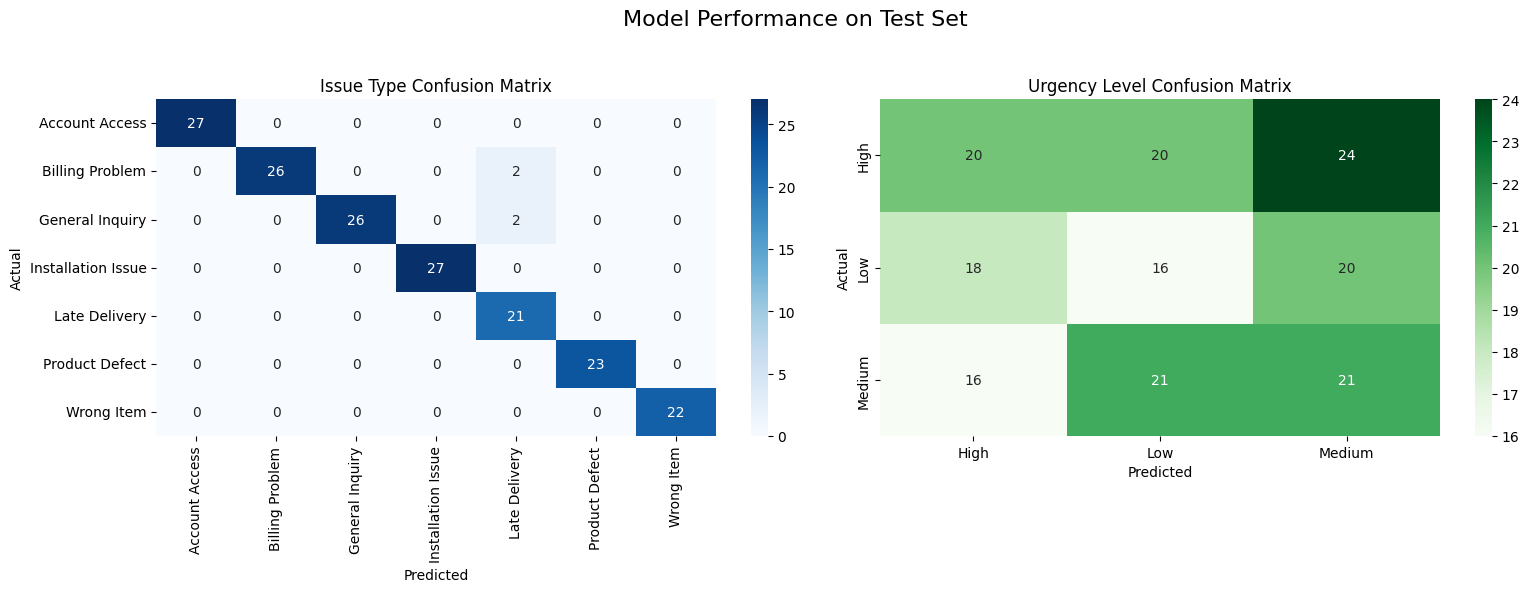

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance on Test Set', fontsize=16)

# Issue type confusion matrix
cm_issue = confusion_matrix(y_issue_test, issue_pred_test)
sns.heatmap(cm_issue, annot=True, fmt='d', cmap='Blues',
            xticklabels=classifier.label_encoders['issue'].classes_,
            yticklabels=classifier.label_encoders['issue'].classes_, ax=axes[0])
axes[0].set_title('Issue Type Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Urgency level confusion matrix
cm_urgency = confusion_matrix(y_urgency_test, urgency_pred_test)
sns.heatmap(cm_urgency, annot=True, fmt='d', cmap='Greens',
            xticklabels=classifier.label_encoders['urgency'].classes_,
            yticklabels=classifier.label_encoders['urgency'].classes_, ax=axes[1])
axes[1].set_title('Urgency Level Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()